In [1]:
from myutils import (
    get_rolling_kelly, process_data, get_historical_var, calculate_daily_rf, get_cumulative_returns,
    get_cumulative_trix_returns
)
import pandas as pd
import matplotlib.pyplot as plt

sp500 = pd.read_csv('SP500_mine.csv')
sp500 = process_data(sp500)

In [2]:
# rebalance_interval = 60
var_confidence = 0.005
window = 400

In [3]:
# ema = 이동평균, ewm: 이동평균 구하는 함수
def calculate_trix(close_prices, n):
    ema1 = close_prices.ewm(span=n, min_periods=n).mean()
    ema2 = ema1.ewm(span=n, min_periods=n).mean()
    ema3 = ema2.ewm(span=n, min_periods=n).mean()
    
    trix = (ema3 - ema3.shift(1)) / ema3.shift(1) * 100
    return trix

# TRIX 값 계산
# sp500['trix'] = calculate_trix(sp500['Price'], n=5)
# sp500['trix_diff'] = sp500['trix'].diff()
# sp500['signal'] = sp500['trix_diff'].rolling(window=2).apply(lambda x: x.prod(), raw=True) >0
# sp500['signal_check'] = sp500['trix_diff'] > 0
# sp500['signal'] = sp500['signal'] & sp500['signal_check'] 
# sp500['sell_signal'] = sp500['signal'] & ~sp500['signal_check']
# sp500['signal'] = sp500['signal'].shift(1)
# sp500['sell_signal'] = sp500['sell_signal'].shift(1)

In [4]:
sp500['trix'] = calculate_trix(sp500['Price'], n=5)
sp500['buy_signal'] = False
sp500['sell_signal'] = False
sp500['trix'] = sp500['trix'].fillna(0)

In [5]:
# 조건에 따라 buy_signal 및 sell_signal 설정
for i in range(1, len(sp500)):
    if sp500.iloc[i]['trix'] < 0 and sp500.iloc[i-1]['trix'] > 0:
        sp500.at[sp500.index[i], 'buy_signal'] = True
    elif sp500.iloc[i]['trix'] > 0 and sp500.iloc[i-1]['trix'] < 0:
        sp500.at[sp500.index[i], 'sell_signal'] = True

In [6]:
# # 매수/매도 신호 감지
# buy_signals = sp500['trix'].diff() > 0
# sell_signals = sp500['trix'].diff() < 0

# # buy_signals과 sell_signals을 사용하여 sp500 DataFrame에 각각 buy_signal과 sell_signal 열 추가
# sp500['buy_signal'] = buy_signals
# sp500['sell_signal'] = sell_signals

# # 매수 신호에 해당하는 행만 선택
# buy_signals = sp500[sp500['buy_signal']]
# sp500.head(30)

In [7]:
sp500[sp500['trix'].isna()]

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal
Date,,,,,,,,,


### 이전 과정 동일 수행

In [8]:
# rf 추가
rf = pd.read_csv('rf_data.csv')
rf.columns = ['Date', 'rf']
rf = calculate_daily_rf(rf, 250)
sp500 = sp500.join(rf)
sp500['rf'] = sp500['rf'].ffill()

In [9]:
# VaR 계산
sp500_var = get_historical_var(sp500, window, var_confidence)

In [10]:
# Kelly 계산
rolling_kelly = get_rolling_kelly(sp500_var)
sp500_var['kelly'] = rolling_kelly

In [11]:
# 정해둔 시점에 대한 값만 겟
index_location = sp500_var.index.get_loc('01/08/2009')
sp500_target = sp500_var.iloc[index_location+1:]

In [12]:
sp500_target[sp500_target['kelly'] < 0]

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal,rf,VaR,kelly
Date,,,,,,,,,,,,
01/09/2009,890.35,909.91,911.93,888.31,-2.13%,-0.0213,0.254039,False,False,0.000097,-0.0893,-2.466456
01/12/2009,870.26,890.40,890.40,864.32,-2.26%,-0.0226,-0.002912,True,False,0.000093,-0.0893,-2.515697
01/13/2009,871.79,869.79,877.02,862.02,0.18%,0.0018,-0.206286,False,False,0.000091,-0.0893,-2.584317
01/14/2009,842.62,867.28,867.28,836.93,-3.35%,-0.0335,-0.454181,False,False,0.000091,-0.0893,-2.770916
01/15/2009,843.74,841.99,851.59,817.04,0.13%,0.0013,-0.631876,False,False,0.000093,-0.0893,-2.803653
...,...,...,...,...,...,...,...,...,...,...,...,...
11/06/2023,4365.98,4364.27,4372.21,4347.53,0.18%,0.0018,0.290700,False,False,0.000094,-0.0404,-0.867260
11/07/2023,4378.38,4366.21,4386.26,4355.41,0.28%,0.0028,0.384703,False,False,0.000092,-0.0404,-0.607260
11/08/2023,4382.78,4384.37,4391.20,4359.76,0.10%,0.0010,0.427617,False,False,0.000089,-0.0404,-0.416157


<Axes: xlabel='Date'>

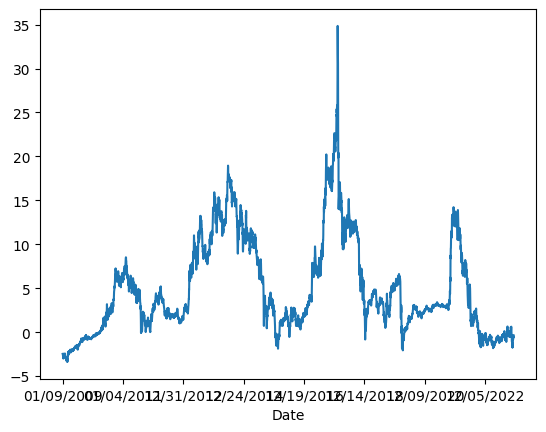

In [13]:
sp500_target['kelly'].plot()

In [14]:
# sp500_target['kelly_ratio'] = sp500_target['kelly'] / 100
sp500_target['kelly_ratio'] = sp500_target['kelly']
sp500_target['kelly_ratio'] = sp500_target['kelly_ratio'].apply(lambda x: x if x < 5 else 5)

/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_3652/2926833342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_target['kelly_ratio'] = sp500_target['kelly']
/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_3652/2926833342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_target['kelly_ratio'] = sp500_target['kelly_ratio'].apply(lambda x: x if x < 5 else 5)


In [15]:
sp500_zero_kelly = sp500_target.copy()
sp500_zero_kelly['kelly_ratio'] = sp500_zero_kelly['kelly_ratio'].apply(lambda x: x if x>0 else 0)

In [16]:
sp500_zero_kelly.head(5)

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal,rf,VaR,kelly,kelly_ratio
Date,,,,,,,,,,,,,
01/09/2009,890.35,909.91,911.93,888.31,-2.13%,-0.0213,0.254039,False,False,0.000097,-0.0893,-2.466456,0.0
01/12/2009,870.26,890.40,890.40,864.32,-2.26%,-0.0226,-0.002912,True,False,0.000093,-0.0893,-2.515697,0.0
01/13/2009,871.79,869.79,877.02,862.02,0.18%,0.0018,-0.206286,False,False,0.000091,-0.0893,-2.584317,0.0
01/14/2009,842.62,867.28,867.28,836.93,-3.35%,-0.0335,-0.454181,False,False,0.000091,-0.0893,-2.770916,0.0
01/15/2009,843.74,841.99,851.59,817.04,0.13%,0.0013,-0.631876,False,False,0.000093,-0.0893,-2.803653,0.0


In [17]:
sp500_result_var_kelly = sp500_zero_kelly.copy()
sp500_result_var_kelly['check'] = (sp500_result_var_kelly['Change'] - sp500_result_var_kelly['trix'])/(100 * abs(sp500_result_var_kelly['Change']))
sp500_result_var_kelly

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal,rf,VaR,kelly,kelly_ratio,check
Date,,,,,,,,,,,,,,
01/09/2009,890.35,909.91,911.93,888.31,-2.13%,-0.0213,0.254039,False,False,0.000097,-0.0893,-2.466456,0.0,-0.129267
01/12/2009,870.26,890.40,890.40,864.32,-2.26%,-0.0226,-0.002912,True,False,0.000093,-0.0893,-2.515697,0.0,-0.008712
01/13/2009,871.79,869.79,877.02,862.02,0.18%,0.0018,-0.206286,False,False,0.000091,-0.0893,-2.584317,0.0,1.156032
01/14/2009,842.62,867.28,867.28,836.93,-3.35%,-0.0335,-0.454181,False,False,0.000091,-0.0893,-2.770916,0.0,0.125576
01/15/2009,843.74,841.99,851.59,817.04,0.13%,0.0013,-0.631876,False,False,0.000093,-0.0893,-2.803653,0.0,4.870585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/06/2023,4365.98,4364.27,4372.21,4347.53,0.18%,0.0018,0.290700,False,False,0.000094,-0.0404,-0.867260,0.0,-1.605002
11/07/2023,4378.38,4366.21,4386.26,4355.41,0.28%,0.0028,0.384703,False,False,0.000092,-0.0404,-0.607260,0.0,-1.363939
11/08/2023,4382.78,4384.37,4391.20,4359.76,0.10%,0.0010,0.427617,False,False,0.000089,-0.0404,-0.416157,0.0,-4.266175


In [18]:
def update_kelly(row):
    if row['VaR'] >= row['Change']:
        return 0
    else:
        return row['kelly_ratio']

# def update_kelly(row):
#     if row['VaR'] > row['trix']:
#         return 0
#     else:
#         return row['kelly_ratio']
    
# sp500_result_var_kelly = sp500_zero_kelly.copy()
# apply 함수를 사용하여 kelly_ratio 업데이트
sp500_result_var_kelly['kelly_ratio'] = sp500_result_var_kelly.apply(lambda row: update_kelly(row), axis=1)

In [19]:
sp500_result = get_cumulative_trix_returns(sp500_target)
sp500_result_zero_kelly = get_cumulative_trix_returns(sp500_zero_kelly)
sp500_result_var_kelly = get_cumulative_trix_returns(sp500_result_var_kelly)

/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'portfolio'] = portfolio
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'equity'] = equity
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [20]:
sp500_result_zero_kelly.to_csv('확인.csv')

In [21]:
1.0252**4

1.104674655307801

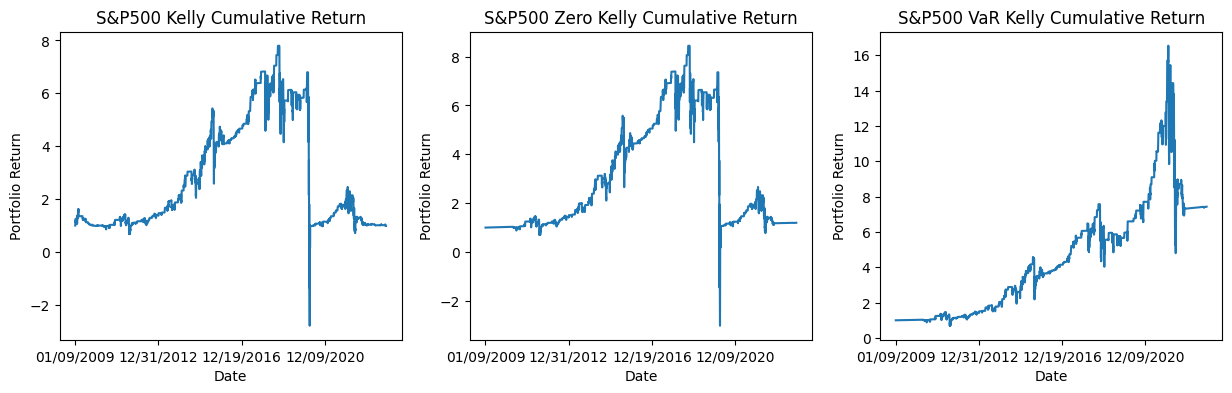

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))

sp500_result['portfolio'].plot(ax=ax[0])
ax[0].set_ylabel('Portfolio Return');
ax[0].set_title('S&P500 Kelly Cumulative Return');

sp500_result_zero_kelly['portfolio'].plot(ax=ax[1])
ax[1].set_ylabel('Portfolio Return');
ax[1].set_title('S&P500 Zero Kelly Cumulative Return');

sp500_result_var_kelly['portfolio'].plot(ax=ax[2])
ax[2].set_ylabel('Portfolio Return');
ax[2].set_title('S&P500 VaR Kelly Cumulative Return');


plt.savefig(f'trix_result/Returns:  var_{str(var_confidence)}, window_{str(window)}.png')

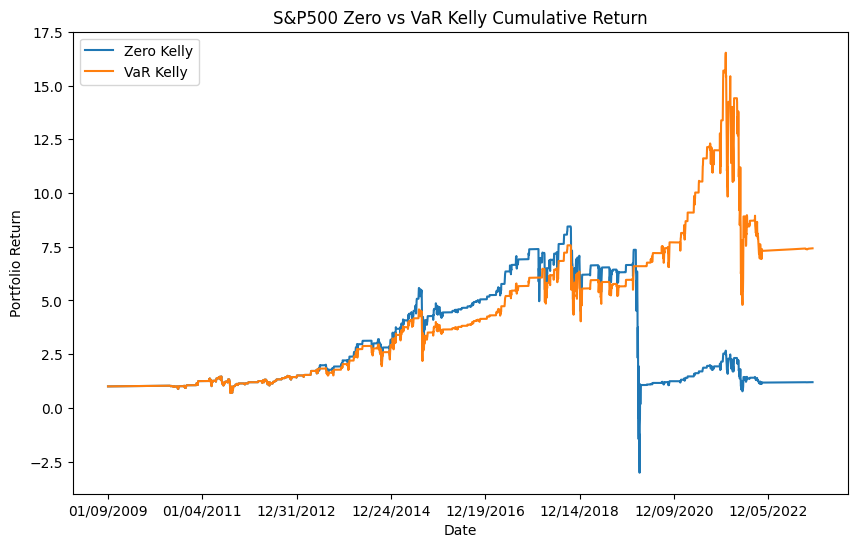

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

sp500_result_zero_kelly['portfolio'].plot(ax=ax, label='Zero Kelly')
sp500_result_var_kelly['portfolio'].plot(ax=ax, label='VaR Kelly')

ax.set_ylabel('Portfolio Return')
ax.set_title('S&P500 Zero vs VaR Kelly Cumulative Return')
ax.legend()

# plt.savefig(f'trix_result/Returns_var_{str(var_confidence)}_window_{str(window)}.png')

In [24]:
sp500_result_var_kelly['portfolio'].max()

16.53373528135412

In [25]:
sp500_result_var_kelly['portfolio'].tail(5)

Date
11/06/2023    7.424567
11/07/2023    7.425251
11/08/2023    7.425912
11/09/2023    7.426614
11/10/2023    7.427312
Name: portfolio, dtype: float64

In [26]:
sp500_result_var_kelly[sp500_result_var_kelly['portfolio']>5]

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal,rf,VaR,kelly,kelly_ratio,check,portfolio,equity,cash
Date,,,,,,,,,,,,,,,,,
05/22/2017,2394.02,2387.21,2395.46,2386.92,0.52%,0.0052,-0.062916,False,False,0.000031,-0.0250,6.894440,5.0,0.130993,5.104429,24.037280,-18.932851
05/23/2017,2398.42,2397.04,2400.85,2393.88,0.18%,0.0018,-0.021682,False,False,0.000032,-0.0250,7.016699,5.0,0.130456,5.147093,24.080547,-18.933455
05/24/2017,2404.39,2401.41,2405.58,2397.99,0.25%,0.0025,0.022978,False,True,0.000032,-0.0250,7.378361,5.0,-0.081913,5.206691,0.000000,5.206691
05/25/2017,2415.07,2409.54,2418.71,2408.01,0.44%,0.0044,0.072768,False,False,0.000032,-0.0250,6.934190,5.0,-0.155382,5.206856,0.000000,5.206856
05/26/2017,2415.82,2414.50,2416.68,2412.20,0.03%,0.0003,0.109565,False,False,0.000031,-0.0250,6.514640,5.0,-3.642174,5.207020,0.000000,5.207020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/06/2023,4365.98,4364.27,4372.21,4347.53,0.18%,0.0018,0.290700,False,False,0.000094,-0.0404,-0.867260,0.0,-1.605002,7.424567,0.000000,7.424567
11/07/2023,4378.38,4366.21,4386.26,4355.41,0.28%,0.0028,0.384703,False,False,0.000092,-0.0404,-0.607260,0.0,-1.363939,7.425251,0.000000,7.425251
11/08/2023,4382.78,4384.37,4391.20,4359.76,0.10%,0.0010,0.427617,False,False,0.000089,-0.0404,-0.416157,0.0,-4.266175,7.425912,0.000000,7.425912


In [27]:
sp500_result_var_kelly.tail(5)

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal,rf,VaR,kelly,kelly_ratio,check,portfolio,equity,cash
Date,,,,,,,,,,,,,,,,,
11/06/2023,4365.98,4364.27,4372.21,4347.53,0.18%,0.0018,0.290700,False,False,0.000094,-0.0404,-0.867260,0.0,-1.605002,7.424567,0.0,7.424567
11/07/2023,4378.38,4366.21,4386.26,4355.41,0.28%,0.0028,0.384703,False,False,0.000092,-0.0404,-0.607260,0.0,-1.363939,7.425251,0.0,7.425251
11/08/2023,4382.78,4384.37,4391.20,4359.76,0.10%,0.0010,0.427617,False,False,0.000089,-0.0404,-0.416157,0.0,-4.266175,7.425912,0.0,7.425912
11/09/2023,4347.35,4391.41,4393.40,4343.94,-0.81%,-0.0081,0.397243,False,False,0.000094,-0.0404,-0.650059,0.0,-0.500424,7.426614,0.0,7.426614
11/10/2023,4415.24,4364.15,4418.03,4353.34,1.56%,0.0156,0.397158,False,False,0.000094,-0.0404,-0.352426,0.0,-0.244588,7.427312,0.0,7.427312


In [28]:
sp500_result_zero_kelly.tail(5)

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal,rf,VaR,kelly,kelly_ratio,portfolio,equity,cash
Date,,,,,,,,,,,,,,,,
11/06/2023,4365.98,4364.27,4372.21,4347.53,0.18%,0.0018,0.290700,False,False,0.000094,-0.0404,-0.867260,0.0,1.196025,0.0,1.196025
11/07/2023,4378.38,4366.21,4386.26,4355.41,0.28%,0.0028,0.384703,False,False,0.000092,-0.0404,-0.607260,0.0,1.196135,0.0,1.196135
11/08/2023,4382.78,4384.37,4391.20,4359.76,0.10%,0.0010,0.427617,False,False,0.000089,-0.0404,-0.416157,0.0,1.196241,0.0,1.196241
11/09/2023,4347.35,4391.41,4393.40,4343.94,-0.81%,-0.0081,0.397243,False,False,0.000094,-0.0404,-0.650059,0.0,1.196355,0.0,1.196355
11/10/2023,4415.24,4364.15,4418.03,4353.34,1.56%,0.0156,0.397158,False,False,0.000094,-0.0404,-0.352426,0.0,1.196467,0.0,1.196467


In [29]:
index_date = sp500_result_var_kelly.index.get_loc('02/02/2022')
sp500_result_var_kelly.iloc[index_date:index_date + 50]

,Price,Open,High,Low,Change %,Change,trix,buy_signal,sell_signal,rf,VaR,kelly,kelly_ratio,check,portfolio,equity,cash
Date,,,,,,,,,,,,,,,,,
02/02/2022,4589.32,4566.39,4595.31,4544.32,0.94%,0.0094,0.058430,False,True,-5.603908e-06,-0.0351,11.833894,5.0,-0.052160,14.249455,0.000000,14.249455
02/03/2022,4477.44,4535.41,4542.88,4470.39,-2.44%,-0.0244,0.119854,False,False,-3.201276e-06,-0.0351,10.489362,5.0,-0.059121,14.249409,0.000000,14.249409
02/04/2022,4500.54,4482.79,4539.66,4451.50,0.52%,0.0052,0.133658,False,False,0.000000e+00,-0.0351,10.955443,5.0,-0.247035,14.249409,0.000000,14.249409
02/07/2022,4483.87,4505.75,4521.86,4471.47,-0.37%,-0.0037,0.111018,False,False,-4.000199e-07,-0.0351,10.632559,5.0,-0.310049,14.249403,0.000000,14.249403
02/08/2022,4521.54,4480.02,4531.32,4465.40,0.84%,0.0084,0.110546,False,False,-4.000199e-07,-0.0351,11.037158,5.0,-0.121602,14.249398,0.000000,14.249398
02/09/2022,4587.18,4547.00,4590.03,4547.00,1.45%,0.0145,0.166829,False,False,-4.000199e-07,-0.0351,11.123852,5.0,-0.105055,14.249392,0.000000,14.249392
02/10/2022,4504.06,4553.24,4588.92,4484.31,-1.81%,-0.0181,0.150343,False,False,1.999502e-06,-0.0351,10.762287,5.0,-0.093063,14.249420,0.000000,14.249420
02/11/2022,4418.64,4506.27,4526.33,4401.41,-1.90%,-0.0190,0.040784,False,False,7.999203e-07,-0.0351,9.772058,5.0,-0.031465,14.249432,0.000000,14.249432
02/14/2022,4401.67,4412.61,4426.22,4364.84,-0.38%,-0.0038,-0.083252,True,False,1.999502e-06,-0.0351,9.400705,5.0,0.209085,14.249460,71.247301,-56.997841
